In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
np.log10(22/14)

0.1962946451439682

In [2]:
################################################################################
################################# READING DATA #################################
################################################################################

fln = 'Kolmogorov_Re40.0_T12500.0_DT01.h5'

with h5py.File(fln, 'r') as f:
    t_recorded_samples = np.array(f['t'])
    snapshot_idx = int(t_recorded_samples.shape[0] / 2)

    D = np.array(f['Dissipation'])

    # u_ref = np.array(f['u_reference'])
    # u_mean = np.sum(u_ref, axis=0) / u_ref.shape[0]
    # u_snapshot = u_ref[snapshot_idx].copy()
    # del(u_ref)
    # v_ref = np.array(f['v_reference'])
    # v_mean = np.sum(v_ref, axis=0) / v_ref.shape[0]
    # v_snapshot = v_ref[snapshot_idx].copy()
    # del(v_ref)
    # vort_ref = np.array(f['vort_reference'])
    # vort_mean = np.sum(vort_ref, axis=0) / vort_ref.shape[0]
    # vort_snapshot = vort_ref[snapshot_idx].copy()
    # del(vort_ref)
    
    u = np.array(f['u'])
    u_mean_org = np.mean(u, axis=0) # np.sum(u, axis=0) / u.shape[0]
    v = np.array(f['v'])
    v_mean_org = np.mean(v, axis=0) # np.sum(v, axis=0) / v.shape[0]

T = t_recorded_samples[-1]

In [3]:
################################################################################
######################## COMPUTING REQUIRED QUANTITIES #########################
################################################################################

### computing KE
u_prime = u - u_mean_org
v_prime = v - v_mean_org
K = np.mean(0.5*(u_prime**2 + v_prime**2), axis=-1) # TKE
K = 0.5*np.mean(K, axis=-1)

uh = np.fft.fftshift(np.fft.fft2(u_prime))
del(u_prime)
del(u)
vh = np.fft.fftshift(np.fft.fft2(v_prime))
del(v_prime)
del(v)
def aap(f1, f2):
    # anti-aliased product
    N = int(0.5*(f1.shape[-1]-1))
    ndim = f1.ndim
    assert ndim < 4, 'input dimensions is greater than 3.'
    if ndim == 2:
        # f1_h, f2_h = np.expand_dims(f1, axis=0).copy(), np.expand_dims(f2, axis=0).copy()
        f1_h, f2_h = np.expand_dims(f1.copy(), axis=0), np.expand_dims(f2.copy(), axis=0)
    elif ndim == 3:
        f1_h, f2_h = f1.copy(), f2.copy()
    
    sz2 = 4*N + 1
    ff1_h = np.zeros((f1_h.shape[0], sz2, sz2), dtype=np.complex128)
    ff2_h = np.zeros((f2_h.shape[0], sz2, sz2), dtype=np.complex128)

    idx1, idx2 = N, 3*N + 1
    ff1_h[:, idx1:idx2, idx1:idx2] = f1_h
    ff2_h[:, idx1:idx2, idx1:idx2] = f2_h

    ff1 = np.fft.irfft2(np.fft.ifftshift(ff1_h), s=ff1_h.shape[-2:])
    ff2 = np.fft.irfft2(np.fft.ifftshift(ff2_h), s=ff2_h.shape[-2:])          # must take real part or use irfft2

    pp_h = (sz2/f1.shape[-1])**2 * np.fft.fft2(ff1*ff2)
    pp_h = np.fft.fftshift(pp_h)

    p_h = pp_h[:, idx1:idx2, idx1:idx2]

    if ndim == 2:
        p_h = p_h[0,:,:]

    return p_h

Ehat = 0.5 * (aap(uh, uh) + aap(vh, vh))
Ehat_mean_abs = np.mean(np.abs(Ehat), axis=0)
del(Ehat)

In [4]:
N = int(0.5*(uh.shape[-1]-1))
domain_len = 2*np.pi

dk = 2*np.pi / domain_len
k = np.arange(-N, N+1)*dk

kk1, kk2 = np.meshgrid(k, k)
kk = kk1**2 + kk2**2

num_circles = int(0.5*(N+1)*(N+2))
# energy_spectrum = np.zeros(shape=num_circles)
energy_spec_kk = np.zeros(shape=num_circles)
print('initial energy_spec_kk shape: ', energy_spec_kk.shape[0])
num_elems = 1
for i in range(1, N+1):
    for j in range(i+1):
        energy_spec_kk[num_elems] = i**2 + j**2
        num_elems += 1
it = 0
while(it < len(energy_spec_kk)):
    elem = energy_spec_kk[it]
#     temp = []
#     if it > 0:
#         temp.extend(energy_spec_kk[:it])
#     if it+1 < len(energy_spec_kk):
#         temp.extend(energy_spec_kk[it+1:])
#     temp = np.array(temp)
    idx = np.where(energy_spec_kk == elem)[0]
    idx = np.setdiff1d(idx, [it])
    if len(idx) > 0:
        idx_new = np.setdiff1d(np.arange(energy_spec_kk.shape[0]), idx)
        energy_spec_kk = energy_spec_kk[idx_new]
    it += 1
energy_spec_kk *= dk

energy_spectrum = np.zeros(shape=energy_spec_kk.shape[0])

print('new energy_spec_kk shape: ', energy_spec_kk.shape[0])

initial energy_spec_kk shape:  153
new energy_spec_kk shape:  135


In [5]:
for i in range(len(k)):
    for j in range(len(k)):
        e = Ehat_mean_abs[i, j]
        idx = np.where(energy_spec_kk == kk[i, j])[0]
        if len(idx) > 1:
            print(i, j, idx)
        energy_spectrum[idx] += e

In [6]:
# energy_spec_kk[[61, 85]]
# kk[2, 11]

In [7]:
idx_sort = np.argsort(energy_spec_kk)
energy_spec_kk = energy_spec_kk[idx_sort]**0.5
energy_spectrum = energy_spectrum[idx_sort]

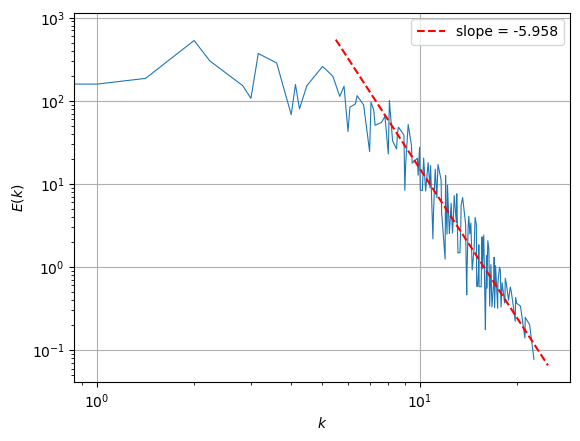

In [15]:
kfit1 = 10
kfit2 = 18

temp = np.abs(energy_spec_kk - kfit1)
idx1 = np.where(temp == np.min(temp))[0][0]
temp = np.abs(energy_spec_kk - kfit2)
idx2 = np.where(temp == np.min(temp))[0][0]

coeffs = np.polyfit(np.log10(energy_spec_kk[idx1:idx2+1]), np.log10(energy_spectrum[idx1:idx2+1]), deg=1)
a = coeffs[0]
b = coeffs[1]

xplot = np.linspace(5.5, 25, 100)
yplot = (10**b) * (xplot**a)

plt.loglog(energy_spec_kk, energy_spectrum, label='_nolegend_', linewidth=0.8)
plt.loglog(xplot, yplot, '--', color='r', label='slope = {:.3f}'.format(a))
plt.grid(True)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$E(k)$')
plt.savefig(fln[0:-3]+'-energy_spec.png', dpi=300, bbox_inches='tight')
plt.show()